In [0]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
tf.config.experimental_run_functions_eagerly(True)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)

def perceptual_loss(y_true, y_pred):
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

In [0]:
#setting image size
image_size = (128, 128, 3)

# setting the data format
K.set_image_data_format('channels_last')

In [0]:
#Naming the model, and loging it
NAME = '40-pl4_blocked-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [0]:
#creating the autoencoder
input_img = Input(shape=image_size) 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss=perceptual_loss, metrics = ['accuracy'])
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
autoencoder.summary()

Model: "model_314"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 64, 64, 32)        0 

In [0]:
# load in the training data: blurred and corresponding original images

pickle_in = open('drive/My Drive/blur.pickle', 'rb')
X1 = pickle.load(pickle_in)
X2 = pickle.load(pickle_in)
X3 = pickle.load(pickle_in)
#X4 = pickle.load(pickle_in)
#X5 = pickle.load(pickle_in)
#X6 = pickle.load(pickle_in)
X = np.concatenate((X1,X2,X3))
del X1, X2,X3


In [0]:
pickle_in1 = open('drive/My Drive/original.pickle', 'rb')
y1 = pickle.load(pickle_in1)
y2 = pickle.load(pickle_in1)
y3 = pickle.load(pickle_in1)
#y4 = pickle.load(pickle_in1)
#y5 = pickle.load(pickle_in1)
#y6 = pickle.load(pickle_in1)
y = np.concatenate((y1,y2,y3))
del y1,y2,y3

In [0]:
print(len(X))

In [0]:
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)

# spliting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

print(X_train.shape)
print(y_train.shape)


(6616, 128, 128, 3)
(6616, 128, 128, 3)
(5954, 128, 128, 3)
(5954, 128, 128, 3)


In [0]:

history = autoencoder.fit(X, y,
                epochs=5,
                batch_size=120,
                shuffle=True,
                validation_data=(X_test, y_test)
                
                )

Epoch 1/5
56/56 [==============================] - 20s 366ms/step - loss: 0.0246 - accuracy: 0.8844 - val_loss: 0.0074 - val_accuracy: 0.9053
Epoch 2/5
56/56 [==============================] - 20s 366ms/step - loss: 0.0062 - accuracy: 0.9102 - val_loss: 0.0053 - val_accuracy: 0.9163
Epoch 3/5
56/56 [==============================] - 20s 366ms/step - loss: 0.0050 - accuracy: 0.9144 - val_loss: 0.0047 - val_accuracy: 0.9183
Epoch 4/5
56/56 [==============================] - 20s 366ms/step - loss: 0.0045 - accuracy: 0.9194 - val_loss: 0.0042 - val_accuracy: 0.9241
Epoch 5/5
56/56 [==============================] - 20s 365ms/step - loss: 0.0044 - accuracy: 0.9242 - val_loss: 0.0042 - val_accuracy: 0.9317


In [0]:
# save the autoencoder model
autoencoder.save(f'drive/My Drive/trained_models/{NAME}.hd5')
print(f"saved - {NAME}")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: drive/My Drive/trained_models/40-pl2.5_blocked-1588661033.hd5/assets
saved - 40-pl2.5_blocked-1588661033


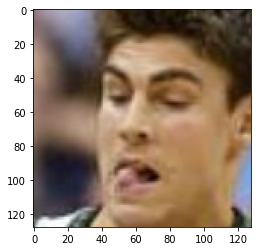

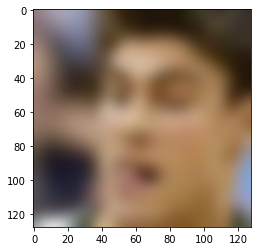

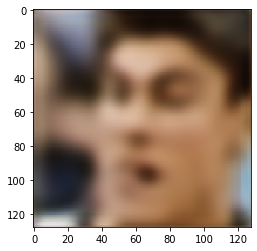

In [0]:
i = 20

#fetch an image from the testing dataset and ask the model to predict the original image
predicted = autoencoder.predict(np.array([X_test[i]]))

#print the obfuscated, original, and predicted image for visual comparison
plt.imshow(y_test[i]) # original
plt.show()
plt.imshow(X_test[i]) # obfuscated
plt.show()
plt.imshow(predicted[0]) # predicted
plt.show()

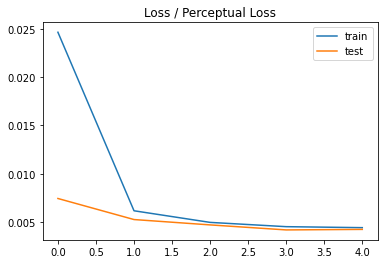

In [0]:
#plotting loss/mse or perceptual loss
from matplotlib import pyplot
pyplot.title('Loss / Perceptual Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
#finding the ssim values
rom skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
predicted = autoencoder.predict(np.array([X_test[2]]))
img=y_test[2]
img_x=X_test[2]
img_noise=predicted[0]
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min(),multichannel=True)
ssim_noise_new = ssim(img, img_x,
                  data_range=img_x.max() - img_x.min(),multichannel=True)
ssim_noise_original = ssim(img, img,
                  data_range=img.max() - img.min(),multichannel=True)
print (ssim_noise)
print (ssim_noise_new)
print (ssim_noise_original)

0.5746679776016149
0.5295582760732289
1.0


In [0]:
#Finding the osnr values
import numpy 
import math
import cv2
original = y_test[20]
predicted = autoencoder.predict(np.array([X_test[20]]))
noisy = X_test[20]
contrast = predicted[0]
contrast = y_test[2]
contrast = X_test[2]
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(original,contrast)
d2 = psnr(original,noisy)
print(d2)

71.53538048927162
